<a href="https://colab.research.google.com/github/AlyaMF/Analysis-of-Activation-Functions-in-CNN/blob/master/CNN_with_Relu_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#         ANALYSIS OF ACTIVATION FUNCTIONS IN CONVOLUTIONAL NEURAL NETWORK 


In this project , I'll train a CNN to classify images from the CIFAR-10 database. The CNN defiend with Relu activation function



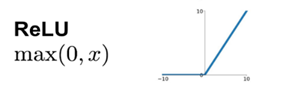

In [44]:
!pip install livelossplot --quiet
!pip install torchsummary

In [0]:
#Load Libraries 
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from livelossplot import PlotLosses


**Utilize GPUs for computation by using TORCH.CUDA package**.

In [46]:
# Check if CUDA available to process data in parallel and spead training time
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


**Load CIFAR-10 Database** 

In [47]:
# number of subprocesses 
num_workers = 0
# number of samples per batch 
batch_size = 20
# percentage of validation set from training set 
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
     # Data Agumentation                           
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # convert images to tensors data types
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normlize RGB values to be between 0-1
    ])

#  Split data
# define the training datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
# define the test datasets
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the 10 image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


**Visualize Data**

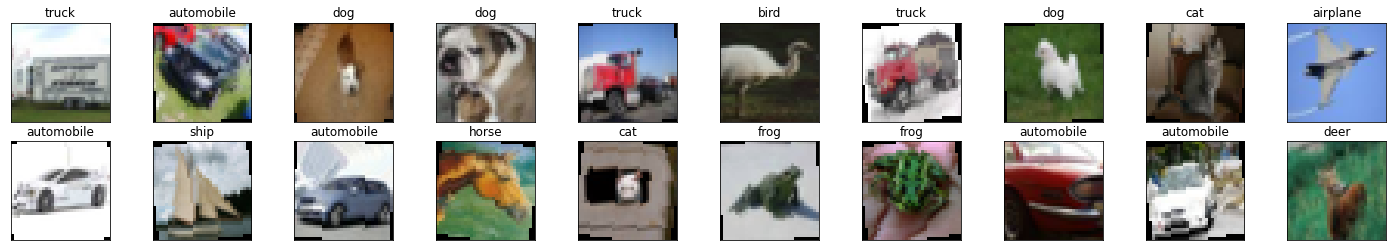

In [48]:
%matplotlib inline

def imshow(img):
  # function to display an image
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image to numpy type for visualization

# get one batch of training images to display them 
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

**Define a CNN architecture**

![CNN](https://www.researchgate.net/profile/Takio_Kurita/publication/320748406/figure/fig1/AS:555719381274624@1509505233044/An-example-of-CNN-architecture.png)

In [49]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1- define convolutional layers in the __init__ function: self.conv = nn.Conv2d(input_depth,Output_depth,Kernel_size, padding)
        # convolutional layer (sees 32x32x3 image tensor) 
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # output will be 32 *32 size
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # output will be 16 *16 size
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # output will be 8 *8 size
        # convolutional layer (sees 8x8x32 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # output will be 4 *4 size

        # 2- define max pooling layer in the __init__ function: self.pool = nn.MaxPool2d(Kernel_size,stride)
        self.pool = nn.MaxPool2d(2, 2)

        # 3- define fully connected layers in the __init__ function: self.fc = nn.Linear(64 * 4 * 4, 500)
        self.fc1 = nn.Linear(128 * 2 * 2, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)

        # To reduce overfitting dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
       
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))  # passing in an input image x and applying a ReLU function to the output of this layer then that poling layer being applied.
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x))) 
        # flatten image input
        x = x.view(-1, 128 * 2 * 2)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
# model summary
summary(model, input_size=(3, 32, 32))

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8] 

**Define the loss and optimizer**

In [0]:
# determine loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# determine weight optimizer 
optimizer = optim.SGD(model.parameters(), lr=0.01)

# SGD is a simple modification to the standard gradient descent algorithm that computes the gradient 
# & updates weights on small batches of training data, rather than the entire training set itself.

**Train the Network**



1. 30 Epochs 




In [51]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
   
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
 
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_30epochs.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 91005.475049 	Validation Loss: 21310.094528
Validation loss decreased (inf --> 21310.094528).  Saving model ...
Epoch: 2 	Training Loss: 76083.683863 	Validation Loss: 16804.665315
Validation loss decreased (21310.094528 --> 16804.665315).  Saving model ...
Epoch: 3 	Training Loss: 66036.889849 	Validation Loss: 15748.322213
Validation loss decreased (16804.665315 --> 15748.322213).  Saving model ...
Epoch: 4 	Training Loss: 61117.699822 	Validation Loss: 14376.927958
Validation loss decreased (15748.322213 --> 14376.927958).  Saving model ...
Epoch: 5 	Training Loss: 57565.170686 	Validation Loss: 13602.855259
Validation loss decreased (14376.927958 --> 13602.855259).  Saving model ...
Epoch: 6 	Training Loss: 54165.115094 	Validation Loss: 12941.159968
Validation loss decreased (13602.855259 --> 12941.159968).  Saving model ...
Epoch: 7 	Training Loss: 51108.209791 	Validation Loss: 12794.908071
Validation loss decreased (12941.159968 --> 12794.908071).  Savi

**Load the Model**

In [52]:
model.load_state_dict(torch.load('model_30epochs.pt'))

<All keys matched successfully>


**Test the Network**

In [55]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
  
    


# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))



for i in range(10):
    if class_total[i] > 0:
         #accurecy = correct_true / number_of_classified_images
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        #recall = correct_true / number_of_actual_true   #number of actual true in each class =1000
        print('Test recall of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / 1000 ,
            np.sum(class_correct[i]), 1000))
      
        
        print('\n ***')
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))







Test Loss: 0.721856

Test Accuracy of airplane: 79% (795/1000)
Test recall of airplane: 79% (795/1000)

 ***
Test Accuracy of automobile: 86% (861/1000)
Test recall of automobile: 86% (861/1000)

 ***
Test Accuracy of  bird: 66% (661/1000)
Test recall of  bird: 66% (661/1000)

 ***
Test Accuracy of   cat: 60% (604/1000)
Test recall of   cat: 60% (604/1000)

 ***
Test Accuracy of  deer: 74% (743/1000)
Test recall of  deer: 74% (743/1000)

 ***
Test Accuracy of   dog: 53% (531/1000)
Test recall of   dog: 53% (531/1000)

 ***
Test Accuracy of  frog: 84% (844/1000)
Test recall of  frog: 84% (844/1000)

 ***
Test Accuracy of horse: 73% (732/1000)
Test recall of horse: 73% (732/1000)

 ***
Test Accuracy of  ship: 85% (857/1000)
Test recall of  ship: 85% (857/1000)

 ***
Test Accuracy of truck: 83% (831/1000)
Test recall of truck: 83% (831/1000)

 ***

Test Accuracy (Overall): 74% (7459/10000)


**Visualize Test Results**

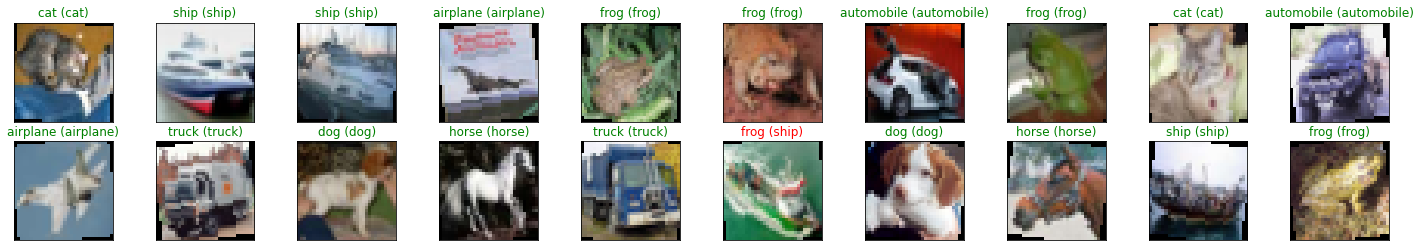

In [56]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))


2. 50 Epochs

In [58]:
# number of epochs to train the model
n_epochs = 50

valid_loss_min = np.Inf # track change in validation loss


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
   
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
 
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_50epochs.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 16902.676974 	Validation Loss: 6898.159547
Validation loss decreased (inf --> 6898.159547).  Saving model ...
Epoch: 2 	Training Loss: 16955.045879 	Validation Loss: 6641.571133
Validation loss decreased (6898.159547 --> 6641.571133).  Saving model ...
Epoch: 3 	Training Loss: 16692.226147 	Validation Loss: 6294.434914
Validation loss decreased (6641.571133 --> 6294.434914).  Saving model ...
Epoch: 4 	Training Loss: 16585.225914 	Validation Loss: 6598.112049
Epoch: 5 	Training Loss: 16515.257891 	Validation Loss: 6670.216203
Epoch: 6 	Training Loss: 16351.587555 	Validation Loss: 6432.181800
Epoch: 7 	Training Loss: 16487.272687 	Validation Loss: 6688.084509
Epoch: 8 	Training Loss: 16393.143145 	Validation Loss: 6684.705607
Epoch: 9 	Training Loss: 16074.516968 	Validation Loss: 6762.770678
Epoch: 10 	Training Loss: 16099.398582 	Validation Loss: 6434.681873
Epoch: 11 	Training Loss: 15968.769352 	Validation Loss: 6423.694852
Epoch: 12 	Training Loss: 16023.1

**Load the Model**

In [59]:
model.load_state_dict(torch.load('model_50epochs.pt'))

<All keys matched successfully>


**Test the Network**

In [61]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
         #accurecy = correct_true / number_of_classified_images
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        #recall = correct_true / number_of_actual_true   #number of actual true in each class =1000
        print('Test recall of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / 1000 ,
            np.sum(class_correct[i]), 1000))
      
        
        print('\n ***')
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))






Test Loss: 0.628901

Test Accuracy of airplane: 81% (812/1000)
Test recall of airplane: 81% (812/1000)

 ***
Test Accuracy of automobile: 84% (848/1000)
Test recall of automobile: 84% (848/1000)

 ***
Test Accuracy of  bird: 73% (738/1000)
Test recall of  bird: 73% (738/1000)

 ***
Test Accuracy of   cat: 64% (644/1000)
Test recall of   cat: 64% (644/1000)

 ***
Test Accuracy of  deer: 77% (770/1000)
Test recall of  deer: 77% (770/1000)

 ***
Test Accuracy of   dog: 67% (674/1000)
Test recall of   dog: 67% (674/1000)

 ***
Test Accuracy of  frog: 84% (844/1000)
Test recall of  frog: 84% (844/1000)

 ***
Test Accuracy of horse: 82% (824/1000)
Test recall of horse: 82% (824/1000)

 ***
Test Accuracy of  ship: 88% (884/1000)
Test recall of  ship: 88% (884/1000)

 ***
Test Accuracy of truck: 87% (879/1000)
Test recall of truck: 87% (879/1000)

 ***

Test Accuracy (Overall): 79% (7917/10000)


**Visualize Test Results**

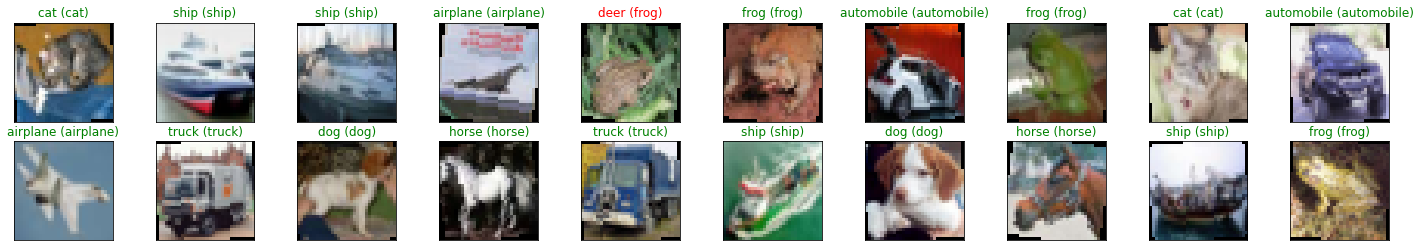

In [60]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
